In [1]:
from gbdxtools import CatalogImage, Interface
import os, sys
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from scipy.misc import bytescale
import shapely
from shapely.wkt import loads
import pandas as pd

%matplotlib inline

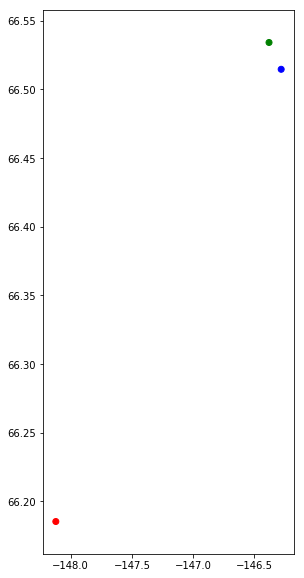

In [2]:
pts_shp = 'sample_pts/sample_pts.shp'
pts = gpd.read_file(pts_shp)

fig, ax = plt.subplots(1, figsize=(4.5,10))
pts.plot(ax=ax,  color=['Red', 'Green', 'Blue'], alpha=1, legend=True)
# ax.legend(loc='middle')
plt.show()

In [3]:
pts

,OID_,Name,FolderPath,SymbolID,AltMode,Base,Snippet,PopupInfo,HasLabel,LabelID,geometry
0,0,YukonWood3,YukonWoodLocations.kmz/YukonWoodLocations,0,-1,0.0,None,None,-1,0,POINT Z (-148.121394976 66.18537990100003 0)
1,0,YukonWood2,YukonWoodLocations.kmz/YukonWoodLocations,0,-1,0.0,None,None,-1,0,POINT Z (-146.379886872 66.53422426900005 0)
2,0,YukonWood1,YukonWoodLocations.kmz/YukonWoodLocations,0,-1,0.0,None,None,-1,0,POINT Z (-146.280645 66.51470300000005 0)


## search the catalog and view as data frames

In [8]:
def flatten_dict(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]

    return dict(items)

def flatten_dict_dg(d):
    def expand(key, value):
        if isinstance(value, dict):
            return [ (key + '.' + k, v) for k, v in flatten_dict(value).items() ]
        else:
            return [ (key, value) ]

    items = [ item for k, v in d.items() for item in expand(k, v) ]
    d = dict(items)
    d['properties.item_type'] = d['properties.item_type'][-1]
    
    return d


## search for other image
from shapely.geometry import box

## construct some queries
# query = 'item_type:QB OR item_type:GE01'
# query = 'item_type:GE01'
# query = 'item_type:QB02'
# query = 'item_type:ESAProduct'
query = 'item_type:WV03_VNIR OR item_type:WV02 OR item_type:QB02 OR item_type:GE01 OR item_type:ESAProduct'

pt_dfs = []
gbdx = Interface()
for i,pt in enumerate(pts['geometry']):
    
    print('searching for point ', i)
    this_bbox = pt.buffer(0.003).bounds # buffering around a point to get a polygon
    aoi = box(*this_bbox).wkt
    recs = gbdx.vectors.query(aoi, query, count=1000) # count keyword default is 100, # results returned
    print(len(recs))
    pt_dfs.append(pd.DataFrame([flatten_dict_dg(r) for r in recs]))


searching for point  0
264
searching for point  1
332
searching for point  2
306


In [9]:
## print out the sensor types for the 3rd point in the geometry set, call it pt0_df

item_type = 'properties.item_type'
pt0_df = pt_dfs[2]
pt0_sensors = pt0_df.groupby(item_type)

print(pt0_sensors)
for name, group in pt0_sensors:
    print('{}: {} available scenes'.format(name, group.shape[0]))

1BProduct: 10 available scenes
GE01: 12 available scenes
QB02: 5 available scenes
SENTINEL2: 250 available scenes
WV02: 21 available scenes
WV03_VNIR: 8 available scenes


In [10]:
## make each item type into a data frame

ls_df = list(pt0_sensors)
df_1B = ls_df[0][1]
df_ge = ls_df[1][1]
df_qb = ls_df[2][1]
df_S2 = ls_df[3][1]
df_wv02 = ls_df[4][1]
df_wv03 = ls_df[5][1]

In [11]:
df_wv02.keys()
df_wv02['properties.attributes.cloudCover_int'][:4],df_wv02['properties.attributes.catalogID'][:4]


(1      0
 16     8
 39    99
 44    99
 Name: properties.attributes.cloudCover_int, dtype: int64,
 1     103001007D0A7D00
 16    103001000A125C00
 39    103001004BD4C000
 44    10300100606A7900
 Name: properties.attributes.catalogID, dtype: object)

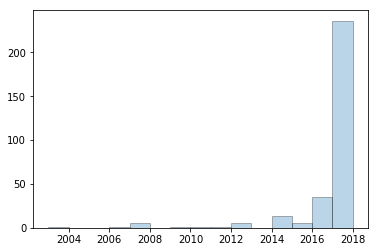

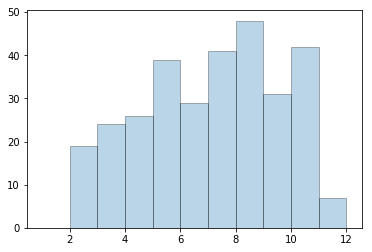

In [15]:
## get the min and max date
years, months = [], []
for entry in pt0_df.iterrows():
    #print(entry[1]['properties.attributes.acquisitionDate'], entry[1]['properties.item_date'])
    item_date = entry[1]['properties.item_date'].split('T')[0].split('-')
    yr = item_date[0]
    mnt = item_date[1]
    day = item_date[2]
    
    years.append(int(yr))
    months.append(int(mnt))
    
plt.figure
plt.hist(years, bins = np.arange(min(years), max(years) + 1), alpha=0.3, edgecolor='k')
plt.show()

plt.figure
plt.hist(months, bins = np.arange(1, 13), alpha=0.3, edgecolor='k')
plt.show()

In [16]:
max_year = max(years)
min_year = min(years)
max_year, min_year

(2018, 2003)

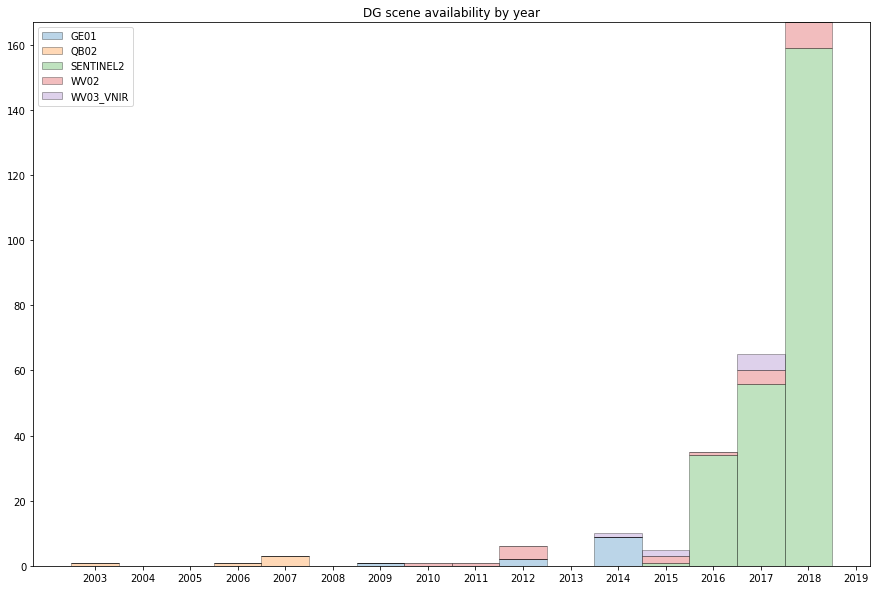

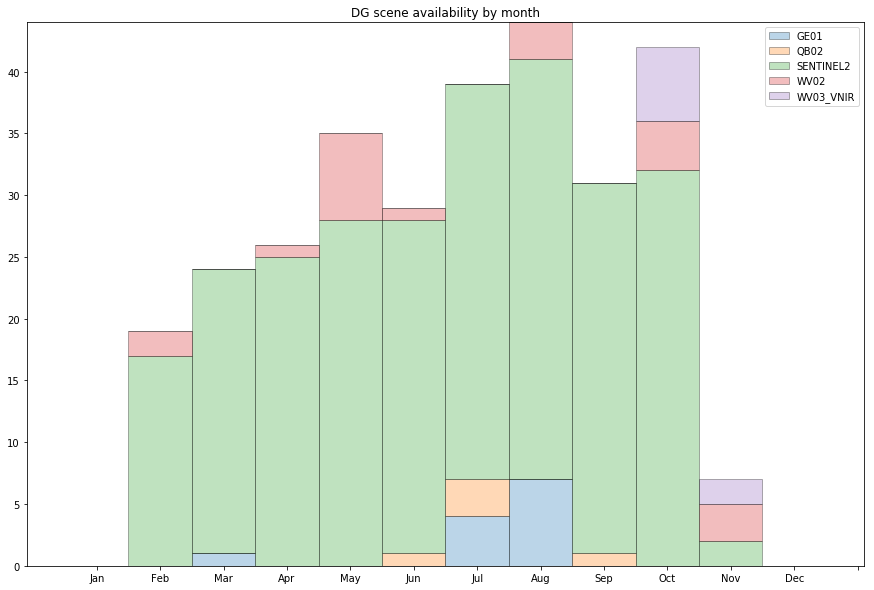

In [18]:
## organize by columns == sensor, stack the histogram

num_sensors = len(pt0_sensors)
num_years = max_year - min_year
yr_bins = np.arange(min_year, max_year+2)

sens_years = np.zeros((num_years, num_sensors))
sens_months = np.zeros((12, num_sensors))

m_bins = np.arange(1,14)

# some lists for bar chart
year_ls, month_ls, labels = [],[], []
for i,group in enumerate(pt0_sensors):
    
    if i==0:
        continue
    
    name, data = group
    labels.append(name)
    
    #print(entry[1]['properties.attributes.acquisitionDate'], entry[1]['properties.item_date'])
    years, months = [], []
    for entry in data.iterrows():
        item_date = entry[1]['properties.item_date'].split('T')[0].split('-')
        yr = item_date[0]
        mnt = item_date[1]
        day = item_date[2]
        
        years.append(int(yr))
        months.append(int(mnt))
        
#     # calculate the histograms
#     y_hist, _ = np.histogram(years, yr_bins)
#     m_hist, _ = np.histogram(months, m_bins)
    
#     # fill out column array
#     sens_years[:,i] = y_hist
#     sens_months[:,i] = m_hist
    
    # append to lists
    year_ls.append(years)
    month_ls.append(months)

fig, ax = plt.subplots(1, figsize=(15,10))
a = ax.hist(year_ls, yr_bins, histtype='bar', stacked=True, alpha=0.3, edgecolor='k', label=labels, align='left')
plt.legend()
ax.set_title('DG scene availability by year')
ax.set_xticks(yr_bins)
plt.show()

fig, ax = plt.subplots(1, figsize=(15,10))
b = ax.hist(month_ls, m_bins, histtype='bar', stacked=True, alpha=0.3, edgecolor='k', label=labels, align='left')
plt.legend()
ax.set_title('DG scene availability by month')
ax.set_xticklabels(('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'))
ax.set_xticks(m_bins)
plt.show()

# p1 = ax.bar(yr_bins, sens_years[:,0])
# for i in range(1, num_sensors):
    

#     plt.bar(yr_bins, sens_years[:,i], bottom=sens_years[:,i-1])
    
# plt.show()


In [19]:
pt0_df

,geometry.coordinates,geometry.type,properties.attributes.acquisitionDate,properties.attributes.attFile,properties.attributes.bands,properties.attributes.bandsList,properties.attributes.browseJpgFile,properties.attributes.browseURL,properties.attributes.bucketName,properties.attributes.bucketPrefix,...,properties.ingest_attributes._rest_user,properties.ingest_date,properties.ingest_source,properties.item_date,properties.item_type,properties.name,properties.original_crs,properties.source,properties.text,type
0,"[[[[-146.5634307, 66.80536507], [-146.1498264,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-11T20:23:47.086Z,GBDX_INGEST_ALPHA,2015-11-18T22:07:39.485Z,WV03_VNIR,None,EPSG:4326,None,,Feature
1,"[[[[-146.52407412, 66.52994681], [-146.0913827...",MultiPolygon,2018-05-22T21:22:59.727Z,NaN,NaN,NaN,NaN,NaN,rda-images-1,NaN,...,idahosvc@digitalglobe.com,2018-07-20T00:31:10.001Z,GBDX_INGEST_ALPHA,2018-05-22T21:22:59.727Z,WV02,None,EPSG:4326,None,,Feature
2,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/4/0,...,sentinelsvc@digitalglobe.com,2018-10-03T01:32:11.419Z,GBDX_INGEST_ALPHA,2018-03-04T21:35:31.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
3,"[[[[-146.1363201, 66.65063882], [-145.9795154,...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T00:24:57.226Z,GBDX_INGEST_ALPHA,2006-09-24T21:35:48.714Z,QB02,None,EPSG:4326,None,,Feature
4,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/11/0,...,sentinelsvc@digitalglobe.com,2018-10-03T00:51:38.169Z,GBDX_INGEST_ALPHA,2018-03-11T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
5,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/3/31/0,...,sentinelsvc@digitalglobe.com,2018-10-03T01:07:47.172Z,GBDX_INGEST_ALPHA,2018-03-31T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
6,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/4/20/0,...,sentinelsvc@digitalglobe.com,2018-10-04T05:13:43.707Z,GBDX_INGEST_ALPHA,2018-04-20T21:25:21.026Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
7,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/9/3/0,...,sentinelsvc@digitalglobe.com,2018-10-03T20:56:16.005Z,GBDX_INGEST_ALPHA,2018-09-03T21:45:31.024Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
8,"[[[-147.00045345910604, 66.71886032839237], [-...",Polygon,NaN,NaN,NaN,"[CoastalAerosol, Blue, Green, Red, VegRedEdge5...",preview.jpg,NaN,sentinel-s2-l1c,tiles/6/W/WU/2018/5/30/0,...,sentinelsvc@digitalglobe.com,2018-10-03T04:51:10.324Z,GBDX_INGEST_ALPHA,2018-05-30T21:25:21.024Z,SENTINEL2,None,EPSG:4326,Sentinel,,Feature
9,"[[[[-146.439062, 66.75334338], [-146.0434548, ...",MultiPolygon,NaN,NaN,NaN,NaN,NaN,https://api.discover.digitalglobe.com/show?id=...,NaN,NaN,...,acquisition-gbdx-support@digitalglobe.com,2017-04-12T02:21:15.128Z,GBDX_INGEST_ALPHA,2003-06-23T21:17:16.607Z,QB02,None,EPSG:4326,None,,Feature


In [20]:
## show the CatalogIDs of the WorldView-2 images
df_wv02['properties.attributes.catalogID']

1      103001007D0A7D00
16     103001000A125C00
39     103001004BD4C000
44     10300100606A7900
51     103001007F46C300
52     1030010004484300
57     103001007D0A7D00
61     103001007D0A7D00
68     103001004E44B200
69     103001007D0A7D00
70     103001007D0A7D00
71     103001007885A400
72     1030010079A55E00
115    103001001AA01200
116    10300100731B9400
154    1030010074BB8A00
155    1030010072853700
191    1030010072755A00
248    1030010019B8C900
263    103001001AB5F300
268    103001001B089200
Name: properties.attributes.catalogID, dtype: object

In [23]:
## store the CatalogIDs if cloud cover is less than some number (cc_thresh)
cc_thresh=20
cat_ids = []
for data_fr in (df_qb, df_wv02, df_wv03):
    
    temp_df = data_fr.loc[data_fr['properties.attributes.cloudCover_int'] < cc_thresh]
    cat_ids.extend(list(temp_df['properties.attributes.catalogID'].values))

In [25]:
cat_ids

['101001000538BA00',
 '1010010005BA1800',
 '1010010005BA1800',
 '1010010005BA1800',
 '103001007D0A7D00',
 '103001000A125C00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007D0A7D00',
 '103001007885A400',
 '1030010079A55E00',
 '103001001AB5F300',
 '103001001B089200',
 '104001001354BC00',
 '104001001324C900',
 '104001000230AB00']

In [26]:
## cat_ids_to_order holds CatalogIDs to use. Try to see if it is available by calling CatalogImage, 
## and if not, add it to a list to order it.
bbox = pts['geometry'][0].buffer(0.003).bounds
ids_to_order = []
for cid in cat_ids:

    try:
        test=CatalogImage(cid)
        print(test.aoi(bbox=bbox).shape, cid, type(test))
    except Exception as e:
        print(e, cid)
        ids_to_order.append(cid)
        

Could not find a catalog entry for the given id: 101001000538BA00 101001000538BA00
 1010010005BA1800
 1010010005BA1800
 1010010005BA1800
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
Could not find a catalog entry for the given id: 103001000A125C00 103001000A125C00
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
(8, 314, 83398) 103001007D0A7D00 <class 'gbdxtools.images.worldview.WV02'>
Could not find a catalog entry for the given id: 103001007885A400 103001007885A400
Could not find a catalog entry for the given id: 1030010079A55E00 1030010079A55E00
Could not find a catalog entry for the given id: 103001001AB5F300 103001001AB5F300
Could not find a catalog entry for the given id: 103001001B089200 103001001B089200
Could not find a catalog entry for the given id: 104001001354BC00 1040010

In [27]:
ids_to_order, cat_ids

(['101001000538BA00',
  '1010010005BA1800',
  '1010010005BA1800',
  '1010010005BA1800',
  '103001000A125C00',
  '103001007885A400',
  '1030010079A55E00',
  '103001001AB5F300',
  '103001001B089200',
  '104001001354BC00',
  '104001001324C900',
  '104001000230AB00'],
 ['101001000538BA00',
  '1010010005BA1800',
  '1010010005BA1800',
  '1010010005BA1800',
  '103001007D0A7D00',
  '103001000A125C00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007D0A7D00',
  '103001007885A400',
  '1030010079A55E00',
  '103001001AB5F300',
  '103001001B089200',
  '104001001354BC00',
  '104001001324C900',
  '104001000230AB00'])

In [67]:
## fire off GDBX workflow to order each image which needs it
## onces the workflows are done processing, the images can be accessed via CatalogImage

order_flag = True
if order_flag:
    bad_id_wfs = []
    gbdx = Interface()
    for bid in cat_ids_to_order:
       
        tasks = []

        # Pre-Image Auto ordering task parameters
        pre_order = gbdx.Task("Auto_Ordering")
        pre_order.inputs.cat_id = bid
        pre_order.impersonation_allowed = True
        pre_order.persist = True
        pre_order.timeout = 36000
        #uc_task.inputs.pre_image_dir = pre_order.outputs.s3_location.value
        tasks += [pre_order]

        # Set up workflow save data
        workflow = gbdx.Workflow(tasks)
        workflow.savedata(pre_order.outputs.s3_location, location='mcglinchy_yukon_data/{}'.format(bid))

        # Execute workflow
        workflow.execute()

        # append to list
        bad_id_wfs.append(workflow)

In [70]:
## check the status for each workflow (order)

for i,wf in enumerate(bad_id_wfs):
    print('workflow id {}, {} of {}'.format(wf.id, i+1, len(bad_id_wfs)))
    print('status: {}'.format(wf.status))
    print('')
           

workflow id 4944132640958835518, 1 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132643153150290, 2 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132645391142718, 3 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132647571587963, 4 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132649755404023, 5 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132652428630995, 6 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132654638746147, 7 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132659220023547, 8 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132661757720788, 9 of 21
status: {u'state': u'complete', u'event': u'succeeded'}

workflow id 4944132664132341542, 10 of 21
status: {u'state': u'pending', u'event': u'waiting'}

workflow id 4944132666442